# MNIST

In [ ]:
from torch import nn
import torch


class MNIST_VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512), nn.ReLU(), nn.Linear(512, 512), nn.ReLU()
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        # sampling latent vector
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)

        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar

In [60]:
from torchvision import datasets, transforms
from torch import optim

from net import VariationalAutoEncoder

EPOCHS = 30
BATCH_SIZE = 128

transform = transforms.Compose(
    [
        transforms.ToTensor(),  # (1, 28, 28)
        transforms.Lambda(lambda x: x.view(-1)),  # (28 * 28,)
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

model = MNIST_VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

vae = VariationalAutoEncoder(
    model, optimizer, BATCH_SIZE, train_dataset, test_dataset, device, beta=1
)

losses = []

for epoch in range(EPOCHS):
    losses += vae.train(epoch)

Epoch #30: 100%|██████████| 469/469 [00:06<00:00, 71.81batch/s, Avg Loss=3658.7468]


In [ ]:
import importlib
import net

import torch

importlib.reload(net)

# torch.save(model.state_dict(), "models/vae.pt")
vae = net.VariationalAutoEncoder(
    model, optimizer, BATCH_SIZE, train_dataset, test_dataset, device, beta=1
)
vae.model.load_state_dict(torch.load("models/vae.pt"))

<All keys matched successfully>

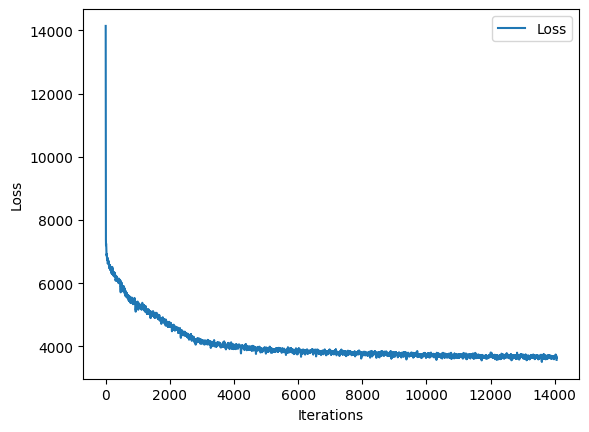

In [62]:
from net import plot_losses

fig, ax = plot_losses(losses, window=10)

Test Set: 100%|██████████| 79/79 [00:00<00:00, 203.37batch/s, Avg Loss=3646.1934]


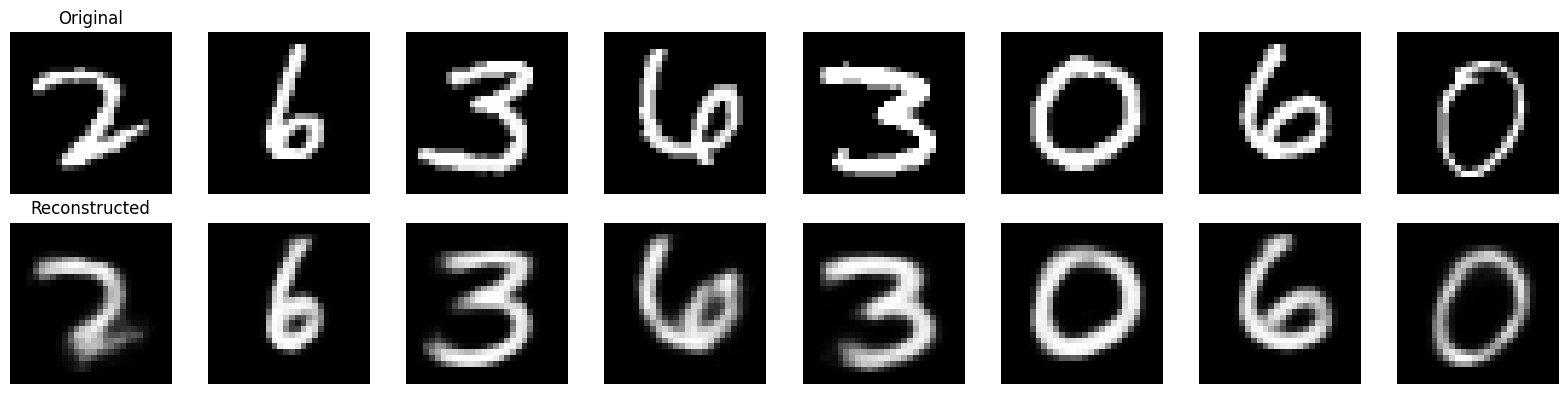

In [63]:
from matplotlib import pyplot as plt

loss = vae.test()


def plot_comparison(images, reconstructed, n=8):
    fig = plt.figure(figsize=(n * 2, 4))

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstructed")

    plt.tight_layout()
    return fig


images, reconstructed = vae.get_batch()
fig = plot_comparison(
    images.view(-1, 28, 28).cpu().detach(),
    reconstructed.view(-1, 28, 28).cpu().detach(),
    n=8,
)

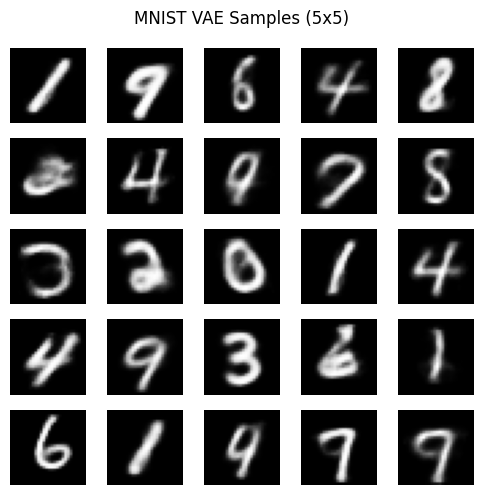

In [66]:
n = 5


def plot_samples(samples, n=5):
    fig = plt.figure(figsize=(n, n))

    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(samples[i], cmap="gray")
        plt.axis("off")

    plt.suptitle(f"MNIST VAE Samples ({n}x{n})")
    plt.tight_layout()

    return fig


samples = vae.sample(n=n * n)
fig = plot_samples(samples.view(-1, 28, 28).cpu().detach(), n=n)

# CIFAR10

In [28]:
import torch
from torch import nn


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class CIFAR_VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 16×16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 8×8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 4×4
            nn.ReLU(),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),  # 2×2
            nn.ReLU(),
            nn.Flatten(),
        )

        self.mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.logvar = nn.Linear(256 * 2 * 2, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 2 * 2),
            View((-1, 256, 2, 2)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 4×4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 8×8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16×16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32×32
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)

        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar

In [ ]:
from torchvision import datasets, transforms
from net import VariationalAutoEncoder

EPOCHS = 30
BATCH_SIZE = 128

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

tensor_transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=tensor_transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=tensor_transform
)

model = CIFAR_VAE(latent_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cifar_vae = VariationalAutoEncoder(
    model, optimizer, BATCH_SIZE, train_dataset, test_dataset, device, beta=0.1
)

losses = []

for epoch in range(EPOCHS):
    losses += cifar_vae.train(epoch)

Epoch #30: 100%|██████████| 391/391 [00:08<00:00, 44.78batch/s, Avg Loss=4497.5619]


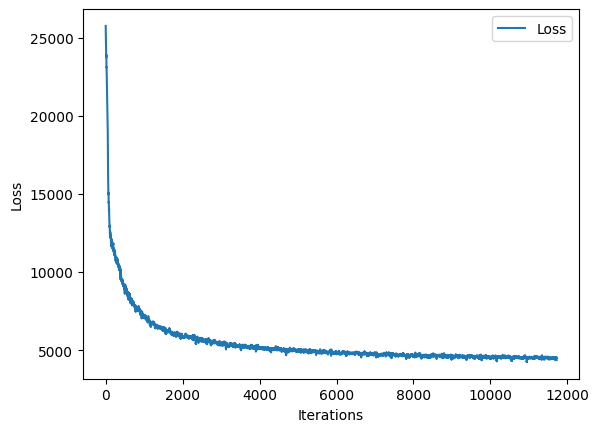

In [ ]:
from net import plot_losses

fig, ax = plot_losses(losses, window=10)

Test Set: 100%|██████████| 79/79 [00:01<00:00, 53.05batch/s, Avg Loss=4489.4253]


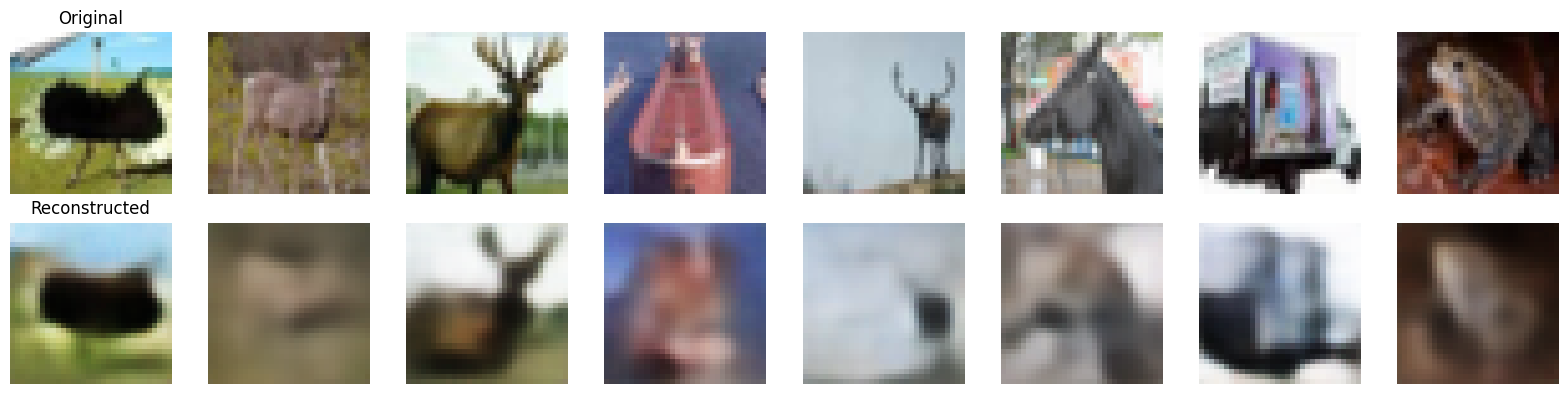

In [38]:
from matplotlib import pyplot as plt

losses = cifar_vae.test()


def plot_comparison(images, reconstructed, n=8):
    fig = plt.figure(figsize=(n * 2, 4))

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].permute(1, 2, 0))
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstructed")

    plt.tight_layout()
    return fig


images, reconstructed = cifar_vae.get_batch()
fig = plot_comparison(images.cpu().detach(), reconstructed.cpu().detach(), n=8)

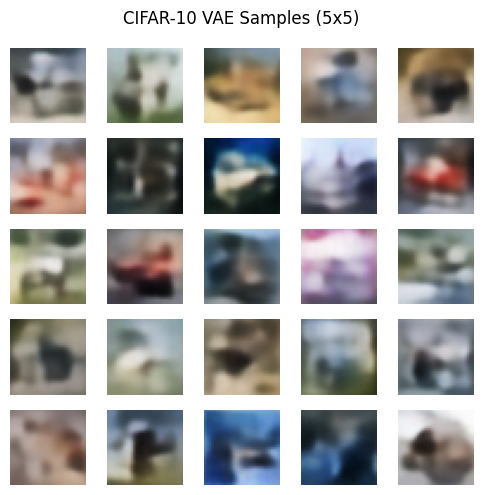

In [66]:
import matplotlib.pyplot as plt


def plot_cifar_samples(samples, n=5):
    fig = plt.figure(figsize=(n, n))

    samples = samples.permute(0, 2, 3, 1)  # (N, H, W, C)

    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(samples[i])
        plt.axis("off")

    plt.suptitle(f"CIFAR-10 VAE Samples ({n}x{n})")
    plt.tight_layout()
    return fig


n = 5
samples = cifar_vae.sample(n=n * n)

fig = plot_cifar_samples(samples.cpu().detach(), n=n)